In [ ]:
import subprocess
import os


def make_fasta(output_dir = "results"):
    os.makedirs(output_dir, exist_ok=True)
    os.chdir(output_dir)

    download_variants = "wget https://ftp-trace.ncbi.nlm.nih.gov/ReferenceSamples/giab/release/NA12878_HG001/latest/GRCh38/HG001_GRCh38_1_22_v4.2.1_benchmark.vcf.gz"
    download_reference_genome = "wget https://ftp-trace.ncbi.nlm.nih.gov/ReferenceSamples/giab/release/references/GRCh38/GCA_000001405.15_GRCh38_no_alt_analysis_set.fasta.gz && gunzip GCA_000001405.15_GRCh38_no_alt_analysis_set.fasta"
    get_biallelic_variants = "bcftools view -v snps -m2 -M2 HG001_GRCh38_1_22_v4.2.1_benchmark.vcf.gz -Oz -o GM12878_SNPs_biallelic.vcf.gz"
    get_index = "bcftools index GM12878_SNPs_biallelic.vcf.gz"
    get_consensus = "bcftools consensus -f GCA_000001405.15_GRCh38_no_alt_analysis_set.fasta -H 1 GM12878_SNPs_biallelic.vcf.gz > GM12878.fasta"

    subprocess.run(download_variants, shell=True)
    subprocess.run(download_reference_genome, shell=True)
    subprocess.run(get_biallelic_variants, shell=True)
    subprocess.run(get_index, shell=True)
    subprocess.run(get_consensus, shell=True)

    os.remove(path="HG001_GRCh38_1_22_v4.2.1_benchmark.vcf.gz")
    os.remove(path="GCA_000001405.15_GRCh38_no_alt_analysis_set.fasta")
    os.remove(path="GM12878_SNPs_biallelic.vcf.gz")
    os.remove(path="GM12878_SNPs_biallelic.vcf.gz.csi")
    
    print(f"Done! Fasta file saved to {output_dir}/GM12878.fasta")

In [ ]:
make_fasta()

In [ ]:
from gtfparse import read_gtf
import polars as pl
from IPython.display import display

In [ ]:
df = read_gtf("/data/common/genome/gencode.v47.basic.annotation.gtf")
filtered_df = df.filter(
    (pl.col('feature') == 'exon') &
    (pl.col('gene_type') == 'protein_coding') &
    (pl.col('seqname').is_in(['chr9']))
)
as_string = filtered_df.with_columns(pl.col('start').cast(pl.Utf8), pl.col('end').cast(pl.Utf8))
as_num = as_string.with_columns(pl.col('exon_number').cast(pl.Int64))
indexed_df = as_num.with_row_index()

display(indexed_df)

In [ ]:
# Get lists of first and last indices
first_indices = []
last_indices = []

for _, group in indexed_df.group_by('transcript_id'):
    sorted_group = group.sort('exon_number')
    first_indices.append(sorted_group.row(0, named=True)['index'])
    last_indices.append(sorted_group.row(-1, named=True)['index'])

# Create update expressions
placeholder_df = indexed_df.with_columns([
    pl.when(pl.col("index").is_in(first_indices))
    .then(pl.lit("START"))
    .otherwise(pl.col("start"))
    .alias("start"),
    
    pl.when(pl.col("index").is_in(last_indices))
    .then(pl.lit("END"))
    .otherwise(pl.col("end"))
    .alias("end")
])

sorted_df = placeholder_df.sort('seqname', 'transcript_id', 'exon_number')

display(sorted_df)

In [ ]:
import polars as pl
from IPython.display import display

In [ ]:
quant_tsv_1 = pl.read_csv("../ENCFF189XTO.tsv", separator='\t')
quant_tsv_2 = pl.read_csv("../ENCFF971DVB.tsv", separator='\t')
display(quant_tsv_1)
display(quant_tsv_2)


In [ ]:
joined_tsv = quant_tsv_1.join(quant_tsv_2, on='transcript_ID', how='inner')
display(joined_tsv)

averaged_counts = joined_tsv.with_columns(
    ((pl.col('rep1ENCSR368UNC') + pl.col('rep2ENCSR368UNC')) / 2).alias('transcript_count')
)
clean_tsv = averaged_counts.select("annot_transcript_id", "annot_transcript_name", "transcript_count")

In [ ]:
import polars as pl 
from gtfparse import read_gtf

In [ ]:
gtf_file = read_gtf("/data/common/genome/gencode.v44.basic.annotation.gtf")
gtf_file.write_parquet("../reference_files/gencode.v44.basic.annotation.gtf.parquet")

In [ ]:
import os
os.chdir("/zata/zippy/ramirezc/splice-model-benchmark")

import sys
splice_transformer_path = os.path.join(f"{os.getcwd}", 'reference_files', 'SpliceTransformer')
sys.path.append(splice_transformer_path)

import pandas as pd
import numpy as np
from pyfaidx import Fasta
import argparse
import vcf as pyvcf
from pyensembl import Genome
import tqdm
import os
from sptransformer import Annotator
import torch

In [ ]:
annotator = Annotator()
gtf = annotator.gtf

tis_names = ['Adipose Tissue', 'Blood', 'Blood Vessel', 'Brain', 'Colon', 'Heart', 'Kidney',
                'Liver', 'Lung', 'Muscle', 'Nerve', 'Small Intestine', 'Skin', 'Spleen', 'Stomach']

input_seq = 'N'*4000 + 'ACGTAGGGCG' + 'N'*4000  # just an example
input_seq = annotator.model.one_hot_encode(input_seq)
input_seq = torch.tensor(input_seq).to(annotator.model.device)
print(input_seq.shape)
# the function step() accepts encoded sequence, (Batch, 4, Length),
# thus, the input_seq should have shape (1, 4, Length)
input_seq = input_seq.unsqueeze(0).float().transpose(1, 2)
output = annotator.model.step(input_seq)
print(output.shape)

In [ ]:
import torch

save_path = 'model/weights/SpTransformer_pytorch.ckpt'
save_dict = torch.load(save_path, map_location='cpu')

new_state_dict = {}
for key, value in save_dict["state_dict"].items():
    if "attn.pos_emb.weights_" in key:
        new_key = key.replace("attn.pos_emb.weights_", "attn.pos_emb.weights.")
        new_state_dict[new_key] = value
    else:
        new_state_dict[key] = value

save_dict["state_dict"] = new_state_dict

new_save_path = 'model/weights/SpTransformer_pytorch_fixed.ckpt'
torch.save(save_dict, new_save_path)

print(f"Modified checkpoint saved to {new_save_path}")

In [ ]:
import torch
from pangolin.model import *
import os
os.chdir("/zata/zippy/ramirezc/splice-model-benchmark")

model_path = "reference_files/pangolin/models/final.{model_index}.{model_num}.3"

model_nums = [0, 2, 4, 6]
models = []
for i in model_nums:
    for j in range(1, 6):
        model = Pangolin(L, W, AR)
        model.cuda()
        weights = torch.load(model_path.format(model_index=j, model_num=i))
        model.load_state_dict(weights)
        model.eval()
        models.append(model)
                
print(models)


In [ ]:
import zarr
import os

In [ ]:
splice_site_predicitons = zarr.open_group(store="/zata/zippy/ramirezc/splice-model-benchmark/results/pangolin_predictions.zarr/splice_site_predictions", mode="r")
splice_site_truth = zarr.open_group(store="/zata/zippy/ramirezc/splice-model-benchmark/results/pangolin_predictions.zarr/splice_site_truth", mode="r")
splice_sites = zarr.open_group(store="/zata/zippy/ramirezc/splice-model-benchmark/results/pangolin_predictions.zarr/splice_sites", mode="r")

In [ ]:
print(splice_site_predicitons["chr1"][11963635])
print(splice_site_truth["chr1"][11963635])

In [ ]:
print(splice_sites['metadata'][:200])

In [ ]:
from nucleotide_transformer.pretrained import get_pretrained_segment_nt_model
import haiku as hk

In [ ]:
parameters, forward_fn, tokenizer, config = get_pretrained_segment_nt_model(
    model_name="segment_nt",
    max_positions=5000 + 1,
)
forward_fn = hk.transform(forward_fn)
donor_idx = config.features.index('splice_donor')
acceptor_idx = config.features.index('splice_acceptor')
print(config.features)

In [ ]:
import os
os.chdir("/zata/zippy/ramirezc/splice-model-benchmark")

import polars as pl
import numpy as np
from models.spliceai import SpliceAIEvaluator
from IPython.display import display

In [ ]:
print([f"chr{i}" for i in range(1, 11, 2)])

In [ ]:
evaluator = SpliceAIEvaluator()
sorted_df = evaluator._filter_gencode()
display(sorted_df)

In [ ]:
quant_tsv_1 = pl.read_csv("reference_files/transcript_quantifications_rep1.tsv", separator='\t')
quant_tsv_2 = pl.read_csv("reference_files/transcript_quantifications_rep2.tsv", separator='\t')
joined_tsv = quant_tsv_1.join(quant_tsv_2, on='transcript_ID', how='inner')
averaged_counts = joined_tsv.with_columns(
    ((pl.col('rep1ENCSR368UNC') + pl.col('rep2ENCSR368UNC')) / 2).alias('transcript_count')
)
clean_tsv = averaged_counts.select("annot_transcript_id", "annot_transcript_name", "transcript_count")
expressed_transcripts = clean_tsv.filter(pl.col('transcript_count') >= 2.0)['annot_transcript_id'].to_list()

gtf = pl.read_parquet("reference_files/gencode.v29.primary_assembly.annotation_UCSC_names.gtf.parquet")
filtered_df = gtf.filter(
    (pl.col('feature') == 'transcript') &
    (pl.col('gene_type') == 'protein_coding') &
    (pl.col('seqname').is_in([f"chr{i}" for i in range(1, 11, 2)])) &
    (pl.col('transcript_id').is_in(expressed_transcripts))
)
display(filtered_df)

In [ ]:
print(f"Average length of transcripts: {np.median((filtered_df['end'].to_numpy() - filtered_df['start'].to_numpy()))}")

In [ ]:
import polars as pl
from IPython.display import display

In [ ]:
vcf = pl.read_csv("HG001_GRCh38_1_22_v4.2.1_benchmark.vcf", separator="\t", comment_prefix="#", new_columns=["CHROM", "POS", "ID", "REF", "ALT", "QUAL", "FILTER", "INFO", "FORMAT", "HG001"])
display(vcf)


In [ ]:
filter_chroms = vcf.filter(pl.col("CHROM").is_in([f"chr{i}" for i in range(1, 11, 2)]))
display(filter_chroms)


In [ ]:
filtered_gtf = pl.read_parquet("filtered_gtf.parquet")
display(filtered_gtf)

In [ ]:
with_start = filtered_gtf.with_columns(
    pl.lit('start').alias('pos_type'),
    pl.col('start').alias('POS'))
with_end = filtered_gtf.with_columns(
    pl.lit('end').alias('pos_type'),
    pl.col('end').alias('POS')
)

concatenated = pl.concat([with_start, with_end])
dropped = concatenated.drop('start', 'end')
to_none = dropped.with_columns(pl.col('POS').replace("EXCLUDE", pl.lit(None)))
as_int = to_none.with_columns(pl.col('POS').cast(pl.Int64))
rename = as_int.with_columns(pl.col('seqname').cast(pl.String).alias('CHROM')).drop('seqname', 'index')
drop_null = rename.drop_nulls(subset=['POS']).with_row_index()

display(drop_null)

In [ ]:
import polars as pl
from IPython.display import display
import os
os.chdir("/zata/zippy/ramirezc/splice-model-benchmark")


print("Filtering GENCODE GTF...")
quant_tsv_1 = pl.read_csv("reference_files/transcript_quantifications_rep1.tsv", separator='\t')
quant_tsv_2 = pl.read_csv("reference_files/transcript_quantifications_rep2.tsv", separator='\t')
joined_tsv = quant_tsv_1.join(quant_tsv_2, on='transcript_ID', how='inner')
averaged_counts = joined_tsv.with_columns(
    ((pl.col('rep1ENCSR368UNC') + pl.col('rep2ENCSR368UNC')) / 2).alias('transcript_count')
)
clean_tsv = averaged_counts.select("annot_transcript_id", "annot_transcript_name", "transcript_count")
expressed_transcripts = clean_tsv.filter(pl.col('transcript_count') >= 2.0)['annot_transcript_id'].to_list()
print(f"Number of expressed transcripts: {len(expressed_transcripts)}")

gtf = pl.read_parquet("reference_files/gencode.v29.primary_assembly.annotation_UCSC_names.gtf.parquet")
filtered_df = gtf.filter(
    (pl.col('feature') == 'exon') &
    (pl.col('gene_type') == 'protein_coding') &
    (pl.col('seqname').is_in(['chr1', 'chr3', 'chr5', 'chr7', 'chr9']))
)
filtered_df = filtered_df.filter(pl.col('transcript_id').is_in(expressed_transcripts))
    
transcript_counts = (
    filtered_df
    .select(['seqname', 'transcript_id'])
    .unique()
    .group_by('seqname')
    .len()
    .sort('seqname')
)
print(f"Number of transcripts per chromsome: {transcript_counts}")

with_start = filtered_df.with_columns(
    pl.lit('start').alias('pos_type'),
    pl.col('start').alias('pos'))
with_end = filtered_df.with_columns(
    pl.lit('end').alias('pos_type'),
    pl.col('end').alias('pos')
)

concatenated = pl.concat([with_start, with_end])
dropped = concatenated.drop('start', 'end')
as_int = dropped.with_columns(pl.col('pos').cast(pl.Int64), pl.col('exon_number').cast(pl.Int64))
sorted_df = as_int.sort('seqname', 'transcript_id', 'exon_number', 'pos')

grouped = sorted_df.group_by('seqname', 'transcript_id').agg(pl.col('pos'))
remove_single_exons = grouped.filter(
    pl.col('pos').list.len() > 2
)
removed_start_and_end = remove_single_exons.with_columns(
    pl.col("pos").list.slice(1, pl.col("pos").list.len() - 2)
    .alias("pos")
)

expoloded_df = removed_start_and_end.explode('pos')
joined_df = sorted_df.join(expoloded_df, on=['seqname', 'transcript_id', 'pos'], how='inner').drop('index').with_row_index()
display(joined_df)

# Drop the first and last exon for each seqname (chrom), transcript_id


# rename = as_int.with_columns(pl.col('seqname').cast(pl.String)).drop('index', 'score')
# drop_null = rename.drop_nulls(subset=['pos']).with_row_index()

# sorted_df = drop_null.sort('seqname', 'transcript_id', 'exon_number')
# display(sorted_df)

In [ ]:
display(joined_df.filter(pl.col('transcript_id') == 'ENST00000643639.1'))

In [ ]:
display(gtf.filter(pl.col('transcript_id') == 'ENST00000610533.4', pl.col('feature') == 'exon').with_columns(pl.col('exon_number').cast(pl.Int64)).sort('seqname', 'exon_number', 'start'))

In [ ]:
idx = 5
nums = [num for num in range(1, 21)]

print(nums[idx:idx+2])
print(nums[(idx-2)  +1:idx + 1])


In [ ]:
# TODO: Find splice site predictions where prediction score is < 0.99 but ground truth is 0.

import polars as pl
from IPython.display import display
import os
import zarr
import xarray as xr
import logomaker
import matplotlib.pyplot as plt
import numpy as np
from pyfaidx import Fasta
from Bio.Seq import reverse_complement
os.chdir("/zata/zippy/ramirezc/splice-model-benchmark")

zarr_root = zarr.group(store=zarr.DirectoryStore("results/spliceai_predictions.zarr"))
acceptor_predictions = zarr_root.require_group('acceptor_predictions')
donor_predictions = zarr_root.require_group('donor_predictions')
acceptor_truth = zarr_root.require_group('acceptor_truth')
donor_truth = zarr_root.require_group('donor_truth')

splice_sites = zarr_root.require_group('splice_sites')
metadata = splice_sites['metadata'][:]

fasta = Fasta("reference_files/GM12878.fasta")
chroms = ['chr1', 'chr3', 'chr5', 'chr7', 'chr9']

schema = {
    'seqname': pl.Utf8,     # For chromosome names
    'start': pl.Int64,      # For genomic coordinates
    'end': pl.Int64,        # For genomic coordinates
    'score': pl.Float64,    # Prediction score from SpliceAI
    'strand': pl.Utf8,      # For '+' or '-'
    'sequence': pl.List(pl.Utf8),    # Consensus di-nucleotide sequence
    'type': pl.Utf8,            # For 'acceptor' or 'donor'
}
splice_sites_dict = {col: [] for col in schema.keys()}

# For future reference:
# 1 is ADDED to the start and end to convert from zarr coords to GTF coords
# For positive-strand acceptors and negative-strand donors, you subtract 2 from the start and  1 from end
# which is the GTF coords for the two positions preceding the exon region.
# For negative-strand acceptors and positive-strand donors, you add 1 to the start and 2 to the end
# which is the GTF coords for the two positions following the exon region.
# For extracting the sequence, we don't need to add 1 since the site['index'] is already the zarr coords.
# The other differences in indexing is due to python index inclusivity (~last_idx).
for site in metadata:
    if site['strand'] == '+':
        if site['type'] == 'acceptor':
            splice_sites_dict['seqname'].append(site['chrom'])
            splice_sites_dict['start'].append(site['index'] + 1 - 2) # Convert back to GTF coords
            splice_sites_dict['end'].append(site['index'] + 1 - 1) # Convert back to GTF coords
            splice_sites_dict['score'].append(acceptor_predictions[site['chrom']][site['index']])
            splice_sites_dict['strand'].append(site['strand'])
            splice_sites_dict['sequence'].append(list(fasta[site['chrom']][site['index'] - 2:site['index']].seq))
            splice_sites_dict['type'].append(site['type'])
        else:
            splice_sites_dict['seqname'].append(site['chrom'])
            splice_sites_dict['start'].append(site['index'] + 1 + 1)
            splice_sites_dict['end'].append((site['index'] + 1 + 2))
            splice_sites_dict['score'].append(donor_predictions[site['chrom']][site['index']])
            splice_sites_dict['strand'].append(site['strand'])
            splice_sites_dict['sequence'].append(list(fasta[site['chrom']][site['index'] + 1:site['index'] + 1 + 2].seq)) # Why + 1? Because python last index is not included
            splice_sites_dict['type'].append(site['type'])
    else:
        if site['type'] == 'acceptor':
            splice_sites_dict['seqname'].append(site['chrom'])
            splice_sites_dict['start'].append(site['index'] + 1 + 1)
            splice_sites_dict['end'].append((site['index'] + 1 + 2))
            splice_sites_dict['score'].append(acceptor_predictions[site['chrom']][site['index']])
            splice_sites_dict['strand'].append(site['strand'])
            splice_sites_dict['sequence'].append(list(reverse_complement(fasta[site['chrom']][site['index'] + 1:site['index'] + 1 + 2].seq)))
            splice_sites_dict['type'].append(site['type'])
        else:
            splice_sites_dict['seqname'].append(site['chrom'])
            splice_sites_dict['start'].append(site['index'] + 1 - 2) # Convert back to GTF coords
            splice_sites_dict['end'].append(site['index'] + 1 - 1) # Convert back to GTF coords'
            splice_sites_dict['score'].append(donor_predictions[site['chrom']][site['index']])
            splice_sites_dict['strand'].append(site['strand'])
            splice_sites_dict['sequence'].append(list(reverse_complement(fasta[site['chrom']][site['index'] - 2:site['index']].seq)))
            splice_sites_dict['type'].append(site['type'])
            
splice_sites_df = pl.from_dict(splice_sites_dict, schema=schema)
splice_sites_df.write_parquet("splice_sites.parquet")
for_tsv = splice_sites_df.with_columns(pl.col('sequence').list.join('').alias('sequence'))
for_tsv.write_csv("splice_sites.tsv", separator='\t')

def create_logo(ax, pwm_df, title):
    motif_logo = logomaker.Logo(pwm_df,
                               shade_below=.5,
                               fade_below=.5,
                               ax=ax)
    
    motif_logo.style_spines(visible=False)
    motif_logo.style_spines(spines=['left', 'bottom'], visible=True)
    motif_logo.style_xticks(rotation=90, fmt='%d', anchor=0)
    
    motif_logo.ax.set_ylabel("probability", labelpad=-1)
    motif_logo.ax.xaxis.set_ticks_position('none')
    motif_logo.ax.xaxis.set_tick_params(pad=-1)
    motif_logo.ax.set_title(title)
    
    return motif_logo

site_types = ['acceptor', 'donor']
fig, axes = plt.subplots(len(chroms), len(site_types), figsize=(len(site_types)*4, len(chroms)*3))

nucleotides = ['A', 'C', 'G', 'T']
positions = list(range(2))
for i, chrom in enumerate(chroms):
    for j, site_type in enumerate(site_types):
        sequences = splice_sites_df.filter(pl.col('seqname') == chrom, pl.col('type') == site_type).get_column('sequence').to_list()
        count_array = xr.DataArray(
            np.zeros((len(positions), len(nucleotides))),
            dims=["pos", "nucleotide"],
            coords={"pos": positions, "nucleotide": nucleotides}
        )
        for seq in sequences:
            for pos in range(len(seq)):
                nt = seq[pos]
                count_array.loc[pos, nt] += 1

        prob_array = count_array / count_array.sum(dim="nucleotide")
        logo_df = prob_array.to_pandas()
        
        title = f"{chrom} - {site_type}"
        create_logo(axes[i, j], logo_df, title)
        
plt.tight_layout()
plt.savefig("motif_grid.svg", format='svg', dpi=300)
plt.show()

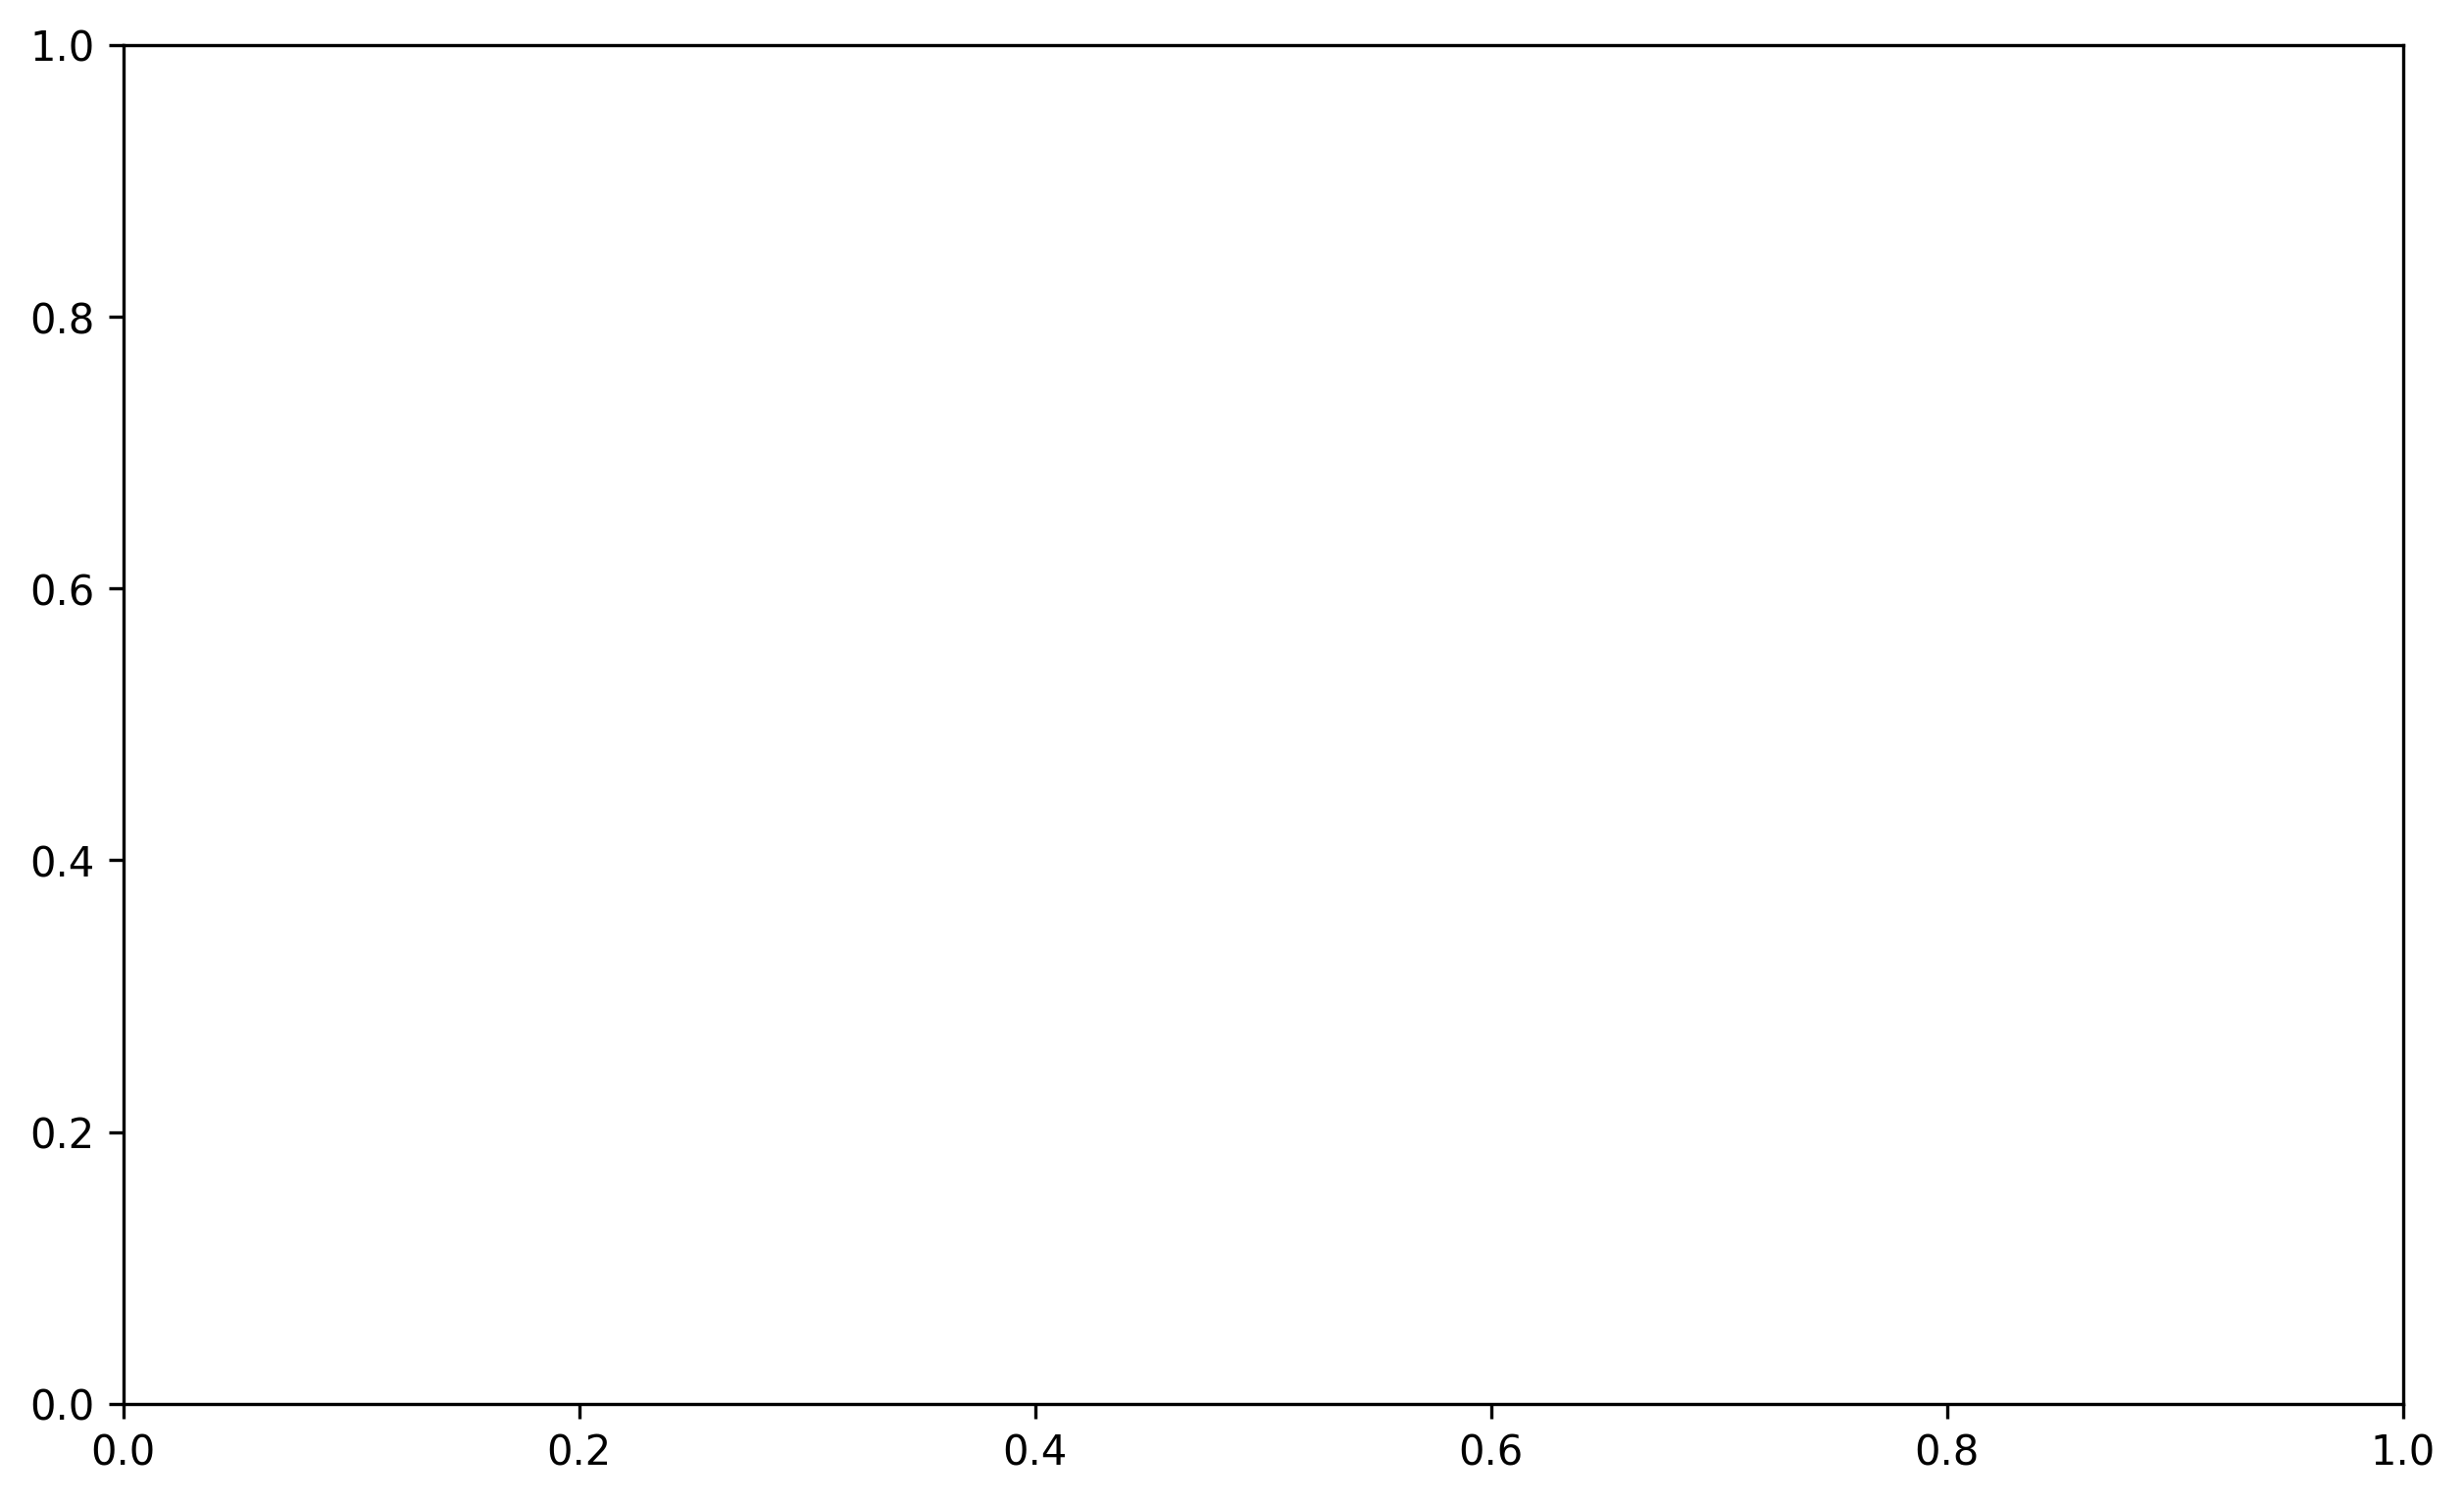

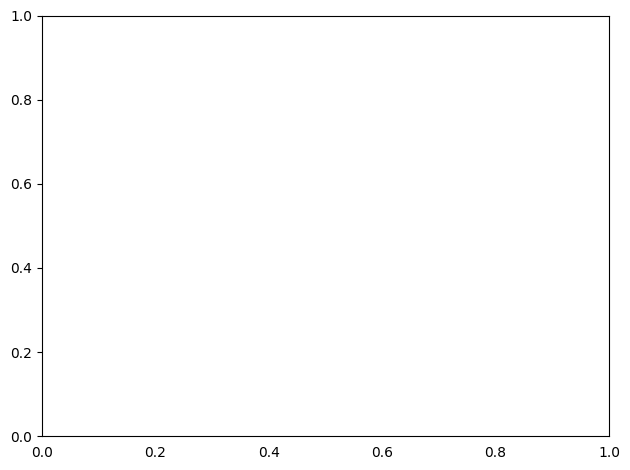

In [ ]:
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import os 
os.chdir("/zata/zippy/ramirezc/splice-model-benchmark")
np.random.seed(42)

splice_sites_df = pl.read_parquet("splice_sites.parquet")
splice_sites_clean = splice_sites_df.with_columns(pl.col('sequence').list.join('').alias('sequence'))

# splice_sites_clean = splice_sites_clean.filter(pl.col('sequence') != 'GT', pl.col('sequence') != 'AG')
total_counts = splice_sites_clean['sequence'].value_counts().sort("count", descending=True).head(20)
sequence_list = total_counts["sequence"].to_list()
counts_list = total_counts["count"].to_list()

x_pos = np.arange(len(sequence_list))

thresholds = np.linspace(0.01, 0.99, 99)
fig, ax = plt.subplots(figsize=(10, 6), dpi=300)

def update(frame):
    threshold = thresholds[frame]
    
    above = splice_sites_clean.filter(pl.col("score") >= threshold)
    above_counts = above['sequence'].value_counts()
    
    above_vals = np.zeros(len(sequence_list))
    below_vals = np.zeros(len(sequence_list))
    
    for i, seq in enumerate(sequence_list):
        total = counts_list[i]
        
        above_match = above_counts.filter(pl.col("sequence") == seq)
        if above_match.height > 0:
            above_vals[i] = above_match["count"][0]
            below_vals[i] = total - above_vals[i]
        else:
            below_vals[i] = total
    
    ax.clear()
    
    ax.bar(x_pos, below_vals, color='skyblue', label='Below Threshold')
    ax.bar(x_pos, above_vals, bottom=below_vals, color='red', label='Above Threshold')
    
    plt.tick_params(bottom=False)
    
    ax.set_xticks(x_pos)
    ax.set_xticklabels(sequence_list, rotation=45)
    ax.set_xlabel('Sequence')
    ax.set_ylabel('Count')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    pct_above = 100 * len(above) / len(splice_sites_clean)
    
    ax.set_title(f'SpliceAI Prediction Threshold: {threshold:.2f}\n{pct_above:.1f}% of sites threshold')
    ax.legend()
    
    plt.tight_layout()
    
anim = FuncAnimation(fig, update, frames=len(thresholds), blit=False, interval=300)
anim.save('sequence_threshold_consensus.gif', writer='pillow', fps=3)